In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tables
import os

In [2]:
f_scan = '/Data2/W53-IF/source_scan/2020_10_22_002/'

print(f_scan)

## add sensor region
rows=768
r_start=1
r_end=768
cloumns=256
c_start=1
c_end=256

measurements = [subdir for subdir in os.listdir(f_scan) if os.path.isfile(os.path.join(f_scan,subdir,'clusterdb.h5'))]
measurements.sort()
print(measurements)

import re

hv_l=[]
drift_l=[]
clear_off_l=[]
for measurement in measurements:
    paras = re.findall('\d+',measurement)
    hv_l.append(paras[0])
    drift_l.append(paras[1])
    clear_off_l.append(paras[2])
hv_l=list(set(hv_l))
drift_l=list(set(drift_l))
clear_off_l=list(set(clear_off_l))

hv_l.sort()
drift_l.sort()
clear_off_l.sort()

hv_l=list(map(int, hv_l))
drift_l=list(map(int,drift_l))
clear_off_l=list(map(int, clear_off_l))

print(hv_l, drift_l, clear_off_l)


/Data2/W53-IF/source_scan/2020_10_22_002/
['hv-58000_drift-4000_clear-off2000', 'hv-58000_drift-4000_clear-off3000', 'hv-58000_drift-4000_clear-off4000', 'hv-58000_drift-5000_clear-off2000', 'hv-58000_drift-5000_clear-off3000', 'hv-58000_drift-5000_clear-off4000', 'hv-58000_drift-6000_clear-off2000', 'hv-58000_drift-6000_clear-off3000', 'hv-58000_drift-6000_clear-off4000', 'hv-60000_drift-4000_clear-off2000', 'hv-60000_drift-4000_clear-off3000', 'hv-60000_drift-4000_clear-off4000', 'hv-60000_drift-5000_clear-off2000', 'hv-60000_drift-5000_clear-off3000', 'hv-60000_drift-5000_clear-off4000', 'hv-60000_drift-6000_clear-off2000', 'hv-60000_drift-6000_clear-off3000', 'hv-60000_drift-6000_clear-off4000', 'hv-62000_drift-4000_clear-off2000', 'hv-62000_drift-4000_clear-off3000', 'hv-62000_drift-4000_clear-off4000', 'hv-62000_drift-5000_clear-off2000', 'hv-62000_drift-5000_clear-off3000', 'hv-62000_drift-5000_clear-off4000', 'hv-62000_drift-6000_clear-off2000', 'hv-62000_drift-6000_clear-off30

In [3]:
######## calculate homogeneity

homogeneity=np.zeros((len(hv_l),len(drift_l),len(clear_off_l)))

for measurement in measurements:    
    clusterdata = tables.open_file(os.path.join(f_scan,measurement,'clusterdb.h5'), mode="r")

    ## calculate homogeneity
    h=0
    for gate in range(192):
        arr = np.asarray([x['signal'] for x in clusterdata.root.cluster.where("""(seed_row >= %i) & (seed_row <%i) & (seed_col >= %i) & (seed_col <= %i)""" 
                                                                    % (4*gate, 4*(gate+1), c_start, c_end))], dtype=np.int)
        mean = arr.mean()
        std = arr.std()
    
        h += mean**2/std
    
    paras = list(map(int, re.findall('\d+',measurement)))
    homogeneity[hv_l.index(paras[0]),drift_l.index(paras[1]),clear_off_l.index(paras[2])] = h
    print(measurement, h)
    
print(homogeneity)   

results_dict={}
results_dict['hv']=hv_l
results_dict['drift']=drift_l
results_dict['clear_off']=clear_off_l
results_dict['homogeneity']=homogeneity
np.save(os.path.join(f_scan,"homogeneity.npy"),results_dict)

hv-58000_drift-4000_clear-off2000 14705.175783993705
hv-58000_drift-4000_clear-off3000 12283.79164407402
hv-58000_drift-4000_clear-off4000 6961.863942777009
hv-58000_drift-5000_clear-off2000 14819.92141511063
hv-58000_drift-5000_clear-off3000 12369.052035758277
hv-58000_drift-5000_clear-off4000 7421.12390987256
hv-58000_drift-6000_clear-off2000 14772.564018370202
hv-58000_drift-6000_clear-off3000 11551.438213675085
hv-58000_drift-6000_clear-off4000 7500.225845411459
hv-60000_drift-4000_clear-off2000 14029.313613846698
hv-60000_drift-4000_clear-off3000 11316.020194406447
hv-60000_drift-4000_clear-off4000 7207.24372744687
hv-60000_drift-5000_clear-off2000 13493.208832769202
hv-60000_drift-5000_clear-off3000 11315.114863078563
hv-60000_drift-5000_clear-off4000 7217.789145152245
hv-60000_drift-6000_clear-off2000 14094.083697926128
hv-60000_drift-6000_clear-off3000 11301.658137572338
hv-60000_drift-6000_clear-off4000 7221.754299097115
hv-62000_drift-4000_clear-off2000 13206.504308677691
hv-

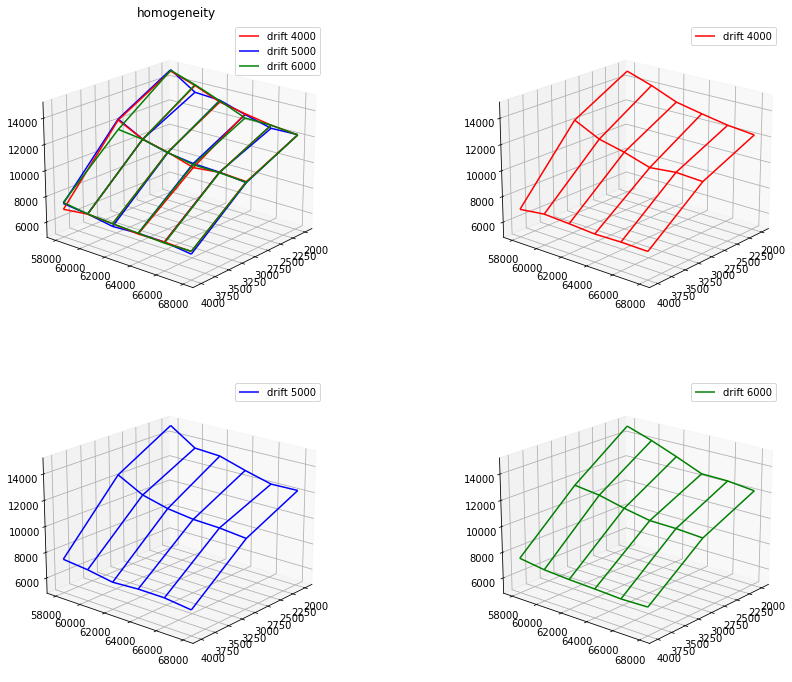

In [7]:
from mpl_toolkits.mplot3d import axes3d

results=np.load(os.path.join(f_scan,"homogeneity.npy"), allow_pickle=True).item()
hv_l=results["hv"]
drift_l=results["drift"]
clear_off_l=results["clear_off"]
homogeneity=results["homogeneity"]

hv_l=list(map(int, hv_l))
drift_l=list(map(int,drift_l))
clear_off_l=list(map(int, clear_off_l))

X, Y = np.meshgrid(clear_off_l,hv_l) 

fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(221, projection='3d')

zmin=5000
zmax=15000

# Plot a basic wireframe.
ax.plot_wireframe(X,Y, homogeneity[:,0,:], color='r',label='drift %s'%(drift_l[0]))
ax.plot_wireframe(X,Y, homogeneity[:,1,:], color='b',label='drift %s'%(drift_l[1]))
ax.plot_wireframe(X,Y, homogeneity[:,2,:], color='g',label='drift %s'%(drift_l[2]))
ax.legend()
ax.set_title("homogeneity")
ax.set_zlim(zmin,zmax)
ax.view_init(20, 40)

ax = fig.add_subplot(222, projection='3d')
ax.plot_wireframe(X,Y, homogeneity[:,0,:], color='r',label='drift %s'%(drift_l[0]))
ax.legend()
ax.set_zlim(zmin,zmax)
ax.view_init(20, 40)

ax = fig.add_subplot(223, projection='3d')
ax.plot_wireframe(X,Y, homogeneity[:,1,:], color='b',label='drift %s'%(drift_l[1]))
ax.legend()
ax.set_zlim(zmin,zmax)
ax.view_init(20, 40)

ax = fig.add_subplot(224, projection='3d')
ax.plot_wireframe(X,Y, homogeneity[:,2,:], color='g',label='drift %s'%(drift_l[2]))
ax.legend()
ax.set_zlim(zmin,zmax)
ax.view_init(20, 40)

plt.draw()
plt.savefig(os.path.join(f_scan,"homogeneity.png"))
